<a href="https://www.kaggle.com/code/klyushnik/s5-e10-let-s-some-blend-0-05554?scriptVersionId=268699006" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


# Welcome!

![mindtitan_artificial_intelligence_road_traffic_accident_prediction_model-1.jpg](https://mindtitan.com/wp-content/uploads/2021/06/mindtitan_artificial_intelligence_road_traffic_accident_prediction_model-1.jpg)

**Welcome to my code! Here I will present my vision and solution for the dataset, where the primary metric is Root Mean Squared Error.**

**Enjoy watching, and please vote!**

**My GitHub: https://github.com/Alexsandrrus!**

# Imports

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
from matplotlib.pyplot import figure

import numpy as np
import pandas as pd
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import mstats
from scipy.stats.mstats import winsorize

from sklearn import preprocessing
from sklearn.preprocessing import (
    LabelEncoder,
    QuantileTransformer,
    StandardScaler,
    PowerTransformer,
    MaxAbsScaler,
    MinMaxScaler,
    RobustScaler,
    PolynomialFeatures,
    OrdinalEncoder,
    OneHotEncoder,
    FunctionTransformer,
    KBinsDiscretizer,
)
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    f_regression,
    SequentialFeatureSelector,
    SelectFromModel
)
from sklearn.model_selection import (
    StratifiedKFold,
    KFold,
    StratifiedGroupKFold,
    RepeatedStratifiedKFold,
    RepeatedKFold,
    cross_validate,
    train_test_split,
    TimeSeriesSplit,
    cross_val_score
)
from sklearn.linear_model import (
    SGDOneClassSVM,
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet,
)
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import (
    HistGradientBoostingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    IsolationForest,
    BaggingRegressor,
    RandomForestRegressor,
    AdaBoostRegressor
)
from sklearn.decomposition import PCA
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error, 
    r2_score,
    make_scorer
)
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.keras.models import clone_model
import keras
from keras_tuner import RandomSearch
from keras import layers
from keras.layers import (
    BatchNormalization,
    Flatten,
    Dense,
    Dropout,
    Activation,
)
from tensorflow.keras.models import Sequential
from keras import backend as K
import keras_tuner
from keras_tuner import Hyperband
from functools import partial

import optuna
from optuna.samplers import CmaEsSampler
from optuna.pruners import MedianPruner
import optuna.visualization as vis

from catboost import CatBoostRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor, StackingCVRegressor
from category_encoders import TargetEncoder, MEstimateEncoder
#from cuml.preprocessing import TargetEncoder

import requests
import holidays
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from category_encoders import CatBoostEncoder, LeaveOneOutEncoder

import warnings
import re
import time
import logging
from functools import partial
from itertools import combinations
from IPython.display import Image

from functools import partial

# Visualization settings
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Pandas settings
pd.options.mode.chained_assignment = None

# Logging configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Warnings configuration
warnings.filterwarnings('ignore')

2025-10-17 11:59:30.288425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760702370.469167      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760702370.533725      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def plot_numerical_features(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.histplot(df[feature], bins=30, kde=True, ax=axes[i], color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].set_ylabel('Frequency', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        mean_value = df[feature].mean()
        axes[i].axvline(mean_value, color='red', linestyle='--', label='Mean')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_numerical_boxplots(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        sns.boxplot(x=df[feature], ax=axes[i], color='lightgreen')
        axes[i].set_title(f'Boxplot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel(feature, fontsize=14)
        axes[i].grid(True, linestyle='--', alpha=0.7)  

        median_value = df[feature].median()
        axes[i].axvline(median_value, color='orange', linestyle='--', label='Median')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

def plot_qq_plot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    ncols = 2
    nrows = (len(num_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(num_features):
        stats.probplot(df[feature], dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ Plot of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Theoretical Quantiles', fontsize=14)
        axes[i].set_ylabel('Sample Quantiles', fontsize=14)
        axes[i].grid(True, linestyle='--', alpha= 0.7)  

    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df, method='spearman'):
    num_df = df.select_dtypes(include=[np.number])
    
    corr = num_df.corr(method=method)
    plt.figure(figsize=(14, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidths=.5)
    plt.title(f'Correlation Matrix ({method.capitalize()} Correlation)', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

def plot_pairplot(df):
    num_features = df.select_dtypes(include=[np.number]).columns
    sns.pairplot(df[num_features], diag_kind='kde', plot_kws={'alpha': 0.6, 'edgecolor': 'k'}, height=2.5)
    plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=18, fontweight='bold')
    plt.show()

def plot_categorical_features(df, ncols=2, top_n=None):
    cat_features = df.select_dtypes(include=[object]).columns
    nrows = (len(cat_features) + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 6 * nrows))
    axes = axes.flatten()

    for i, feature in enumerate(cat_features):
        if top_n is not None:
            top_categories = df[feature].value_counts().nlargest(top_n).index
            sns.countplot(data=df[df[feature].isin(top_categories)], y=feature, ax=axes[i], palette='viridis', order=top_categories)
        else:
            sns.countplot(data=df, y=feature, ax=axes[i], palette='viridis')
        
        axes[i].set_title(f'Count of {feature}', fontsize=18, fontweight='bold')
        axes[i].set_xlabel('Count', fontsize=14)
        axes[i].set_ylabel(feature, fontsize=14)
        axes[i].tick_params(axis='y', rotation=0)
        axes[i].grid(True, linestyle='--', alpha=0.7)  
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def PolynomialFeatures_labeled(input_df,power):
   
    poly = preprocessing.PolynomialFeatures(power)
    output_nparray = poly.fit_transform(input_df)
    powers_nparray = poly.powers_

    input_feature_names = list(input_df.columns)
    target_feature_names = ["Constant Term"]
    for feature_distillation in powers_nparray[1:]:
        intermediary_label = ""
        final_label = ""
        for i in range(len(input_feature_names)):
            if feature_distillation[i] == 0:
                continue
            else:
                variable = input_feature_names[i]
                power = feature_distillation[i]
                intermediary_label = "%s+%d" % (variable,power)
                if final_label == "":         #If the final label isn't yet specified
                    final_label = intermediary_label
                else:
                    final_label = final_label + "x" + intermediary_label
        target_feature_names.append(final_label)
    output_df = pd.DataFrame(output_nparray, columns = target_feature_names)
    return output_df

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]
   
def optimize_memory_usage(df, print_size=True):
    """
    Optimizes memory usage in a DataFrame by downcasting numeric columns.

    Parameters:
        df (pd.DataFrame): The DataFrame to optimize.
        print_size (bool): If True, prints memory usage before and after optimization.

    Returns:
        pd.DataFrame: The optimized DataFrame.
    """
    # Types for optimization.
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    # Memory usage size before optimize (Mb).
    before_size = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        column_type = df[column].dtype
        
        if column_type in numerics:
            try:
                if str(column_type).startswith('int'):
                    df[column] = pd.to_numeric(df[column], downcast='integer')
                else:
                    df[column] = pd.to_numeric(df[column], downcast='float')
                logger.info(f"Optimized column {column}: {column_type} -> {df[column].dtype}")
            except Exception as e:
                logger.error(f"Failed to optimize column {column}: {e}")
    
    # Memory usage size after optimize (Mb).
    after_size = df.memory_usage().sum() / 1024**2
    
    if print_size:
        print(
            'Memory usage size: before {:5.4f} Mb - after {:5.4f} Mb ({:.1f}%).'.format(
                before_size, after_size, 100 * (before_size - after_size) / before_size
            )
        )
    
    return df

def categorize_variable(df, column, labels):
    
    if len(labels) != 3:
        raise ValueError("3 type")
    
    bins = [-float('inf'), 
            df[column].quantile(0.25), 
            df[column].quantile(0.75), 
            float('inf')]
    
    df[f'{column}_group'] = pd.cut(df[column], bins=bins, labels=labels)
    return df

def replace_outliers_with_mean(df, threshold=3):

    df_clean = df.copy()
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        
        z_scores = np.abs(stats.zscore(df[col], nan_policy='omit')) 
        
        mean_val = df[col][z_scores <= threshold].mean()
        
        df_clean[col] = np.where(z_scores > threshold, mean_val, df[col])
        
    return df_clean

# Data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')

display(train.shape, test.shape)
display(train.info(), test.info())

test = test.drop(['id'], axis =1)
train = train.drop(['id'], axis =1)

display(train.describe().T)
display(test.describe().T)

duplicates = train.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

duplicates = test.duplicated()
print(f"Number of duplicates: {duplicates.sum()}")

train = train.drop_duplicates()

for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

display(train.head(5))

(517754, 14)

(172585, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

None

None

,count,mean,std,min,25%,50%,75%,max
num_lanes,517754.0,2.491511,1.120434,1.0,1.00,2.00,3.00,4.0
curvature,517754.0,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,46.112575,15.788521,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,517754.0,1.187970,0.895961,0.0,1.00,1.00,2.00,7.0
accident_risk,517754.0,0.352377,0.166417,0.0,0.23,0.34,0.46,1.0


,count,mean,std,min,25%,50%,75%,max
num_lanes,172585.0,2.494046,1.119148,1.0,1.00,2.00,3.00,4.0
curvature,172585.0,0.487263,0.272343,0.0,0.26,0.51,0.71,1.0
speed_limit,172585.0,46.102761,15.787077,25.0,35.00,45.00,60.00,70.0
num_reported_accidents,172585.0,1.186059,0.897161,0.0,1.00,1.00,2.00,7.0


Number of duplicates: 656
Number of duplicates: 1203
road_type - 0%
num_lanes - 0%
curvature - 0%
speed_limit - 0%
lighting - 0%
weather - 0%
road_signs_present - 0%
public_road - 0%
time_of_day - 0%
holiday - 0%
school_season - 0%
num_reported_accidents - 0%
accident_risk - 0%


,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


# Optimize memory

In [5]:
train = optimize_memory_usage(train)
test = optimize_memory_usage(test)

Memory usage size: before 41.4240 Mb - after 27.1229 Mb (34.5%).
Memory usage size: before 11.1922 Mb - after 7.0775 Mb (36.8%).


# Exploratory Data Analysis

## Numerical feature

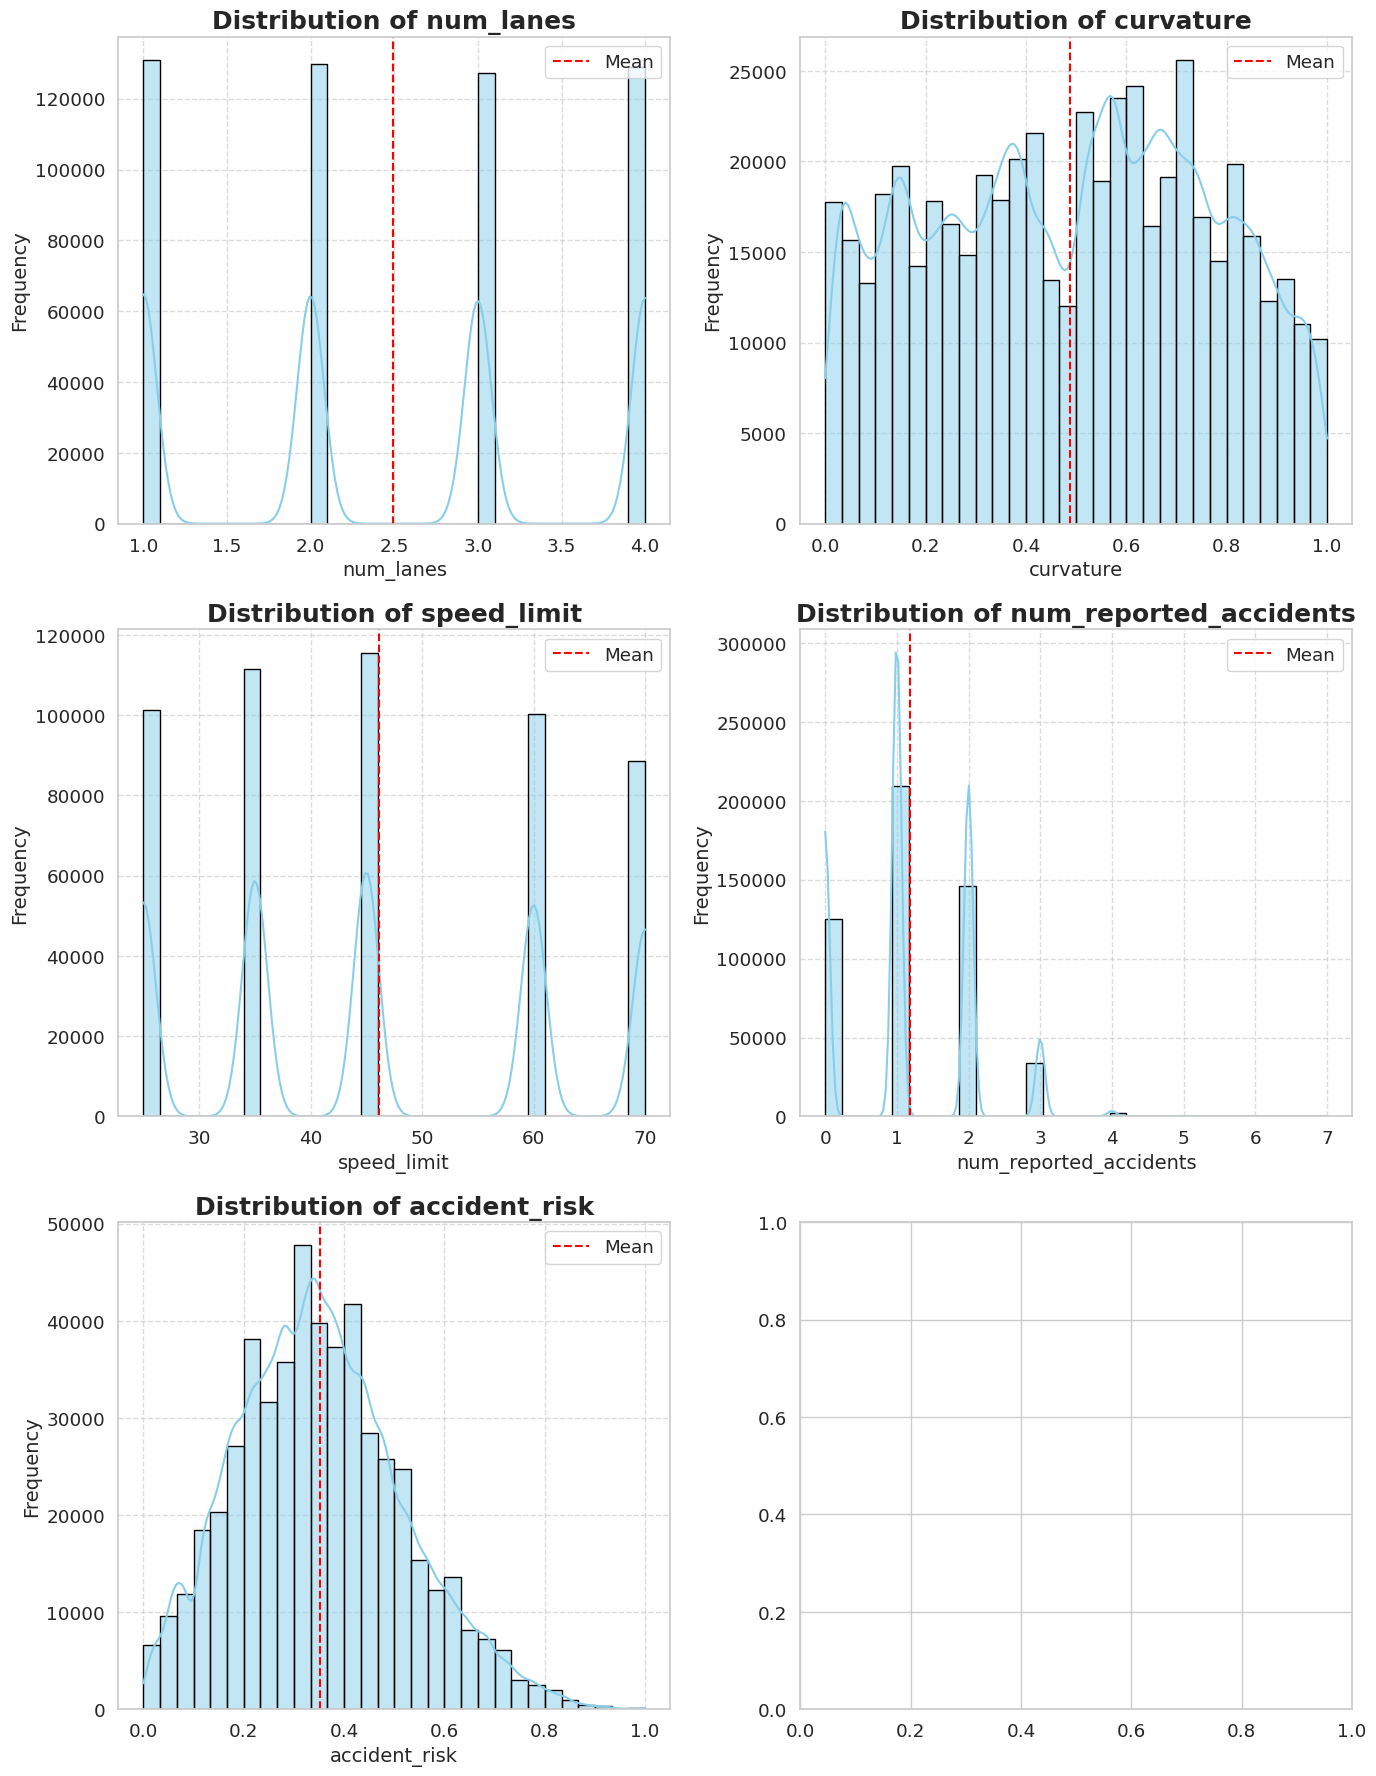

In [6]:
plot_numerical_features(train)

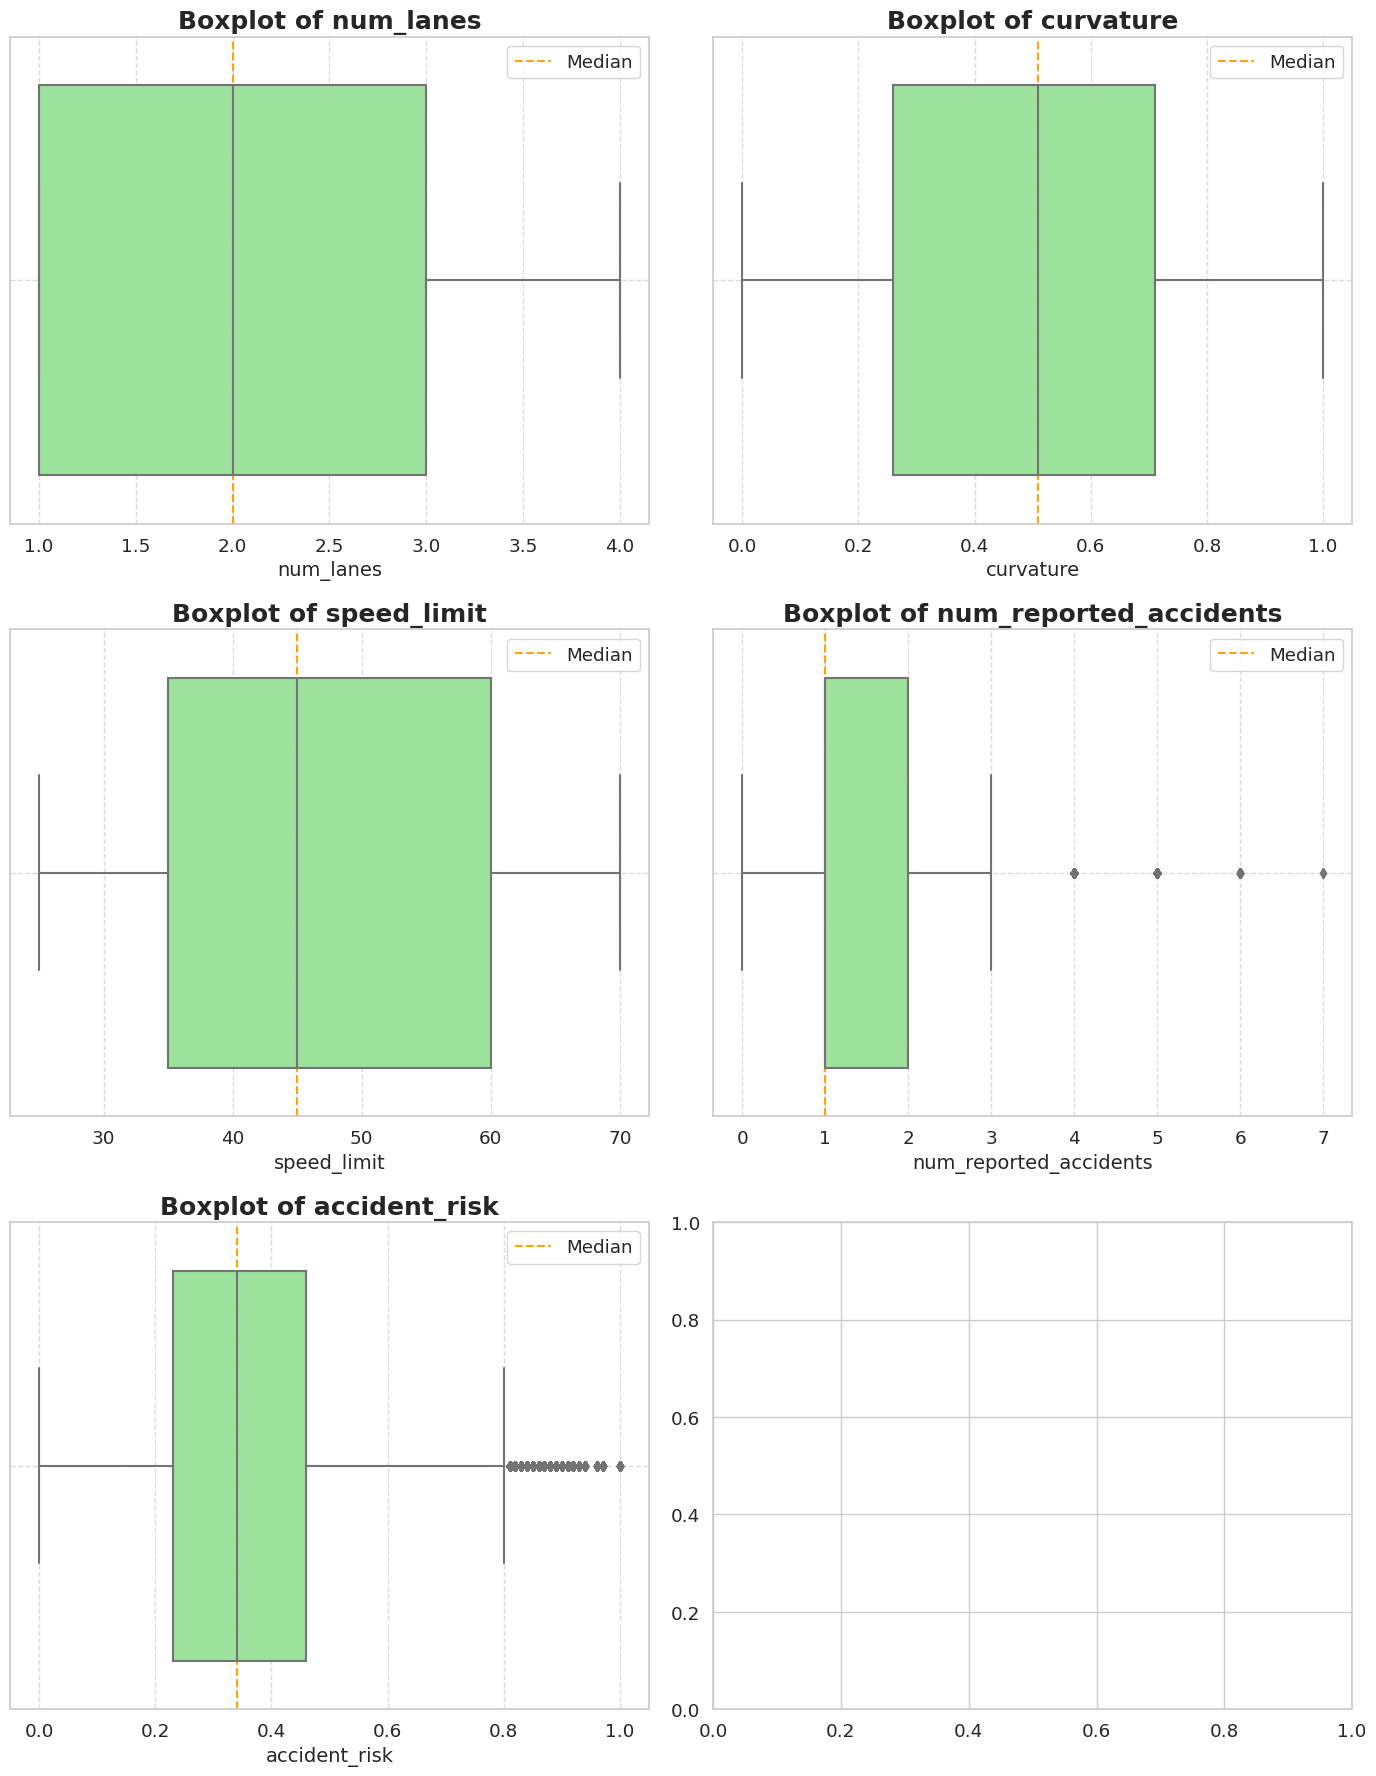

In [7]:
plot_numerical_boxplots(train)

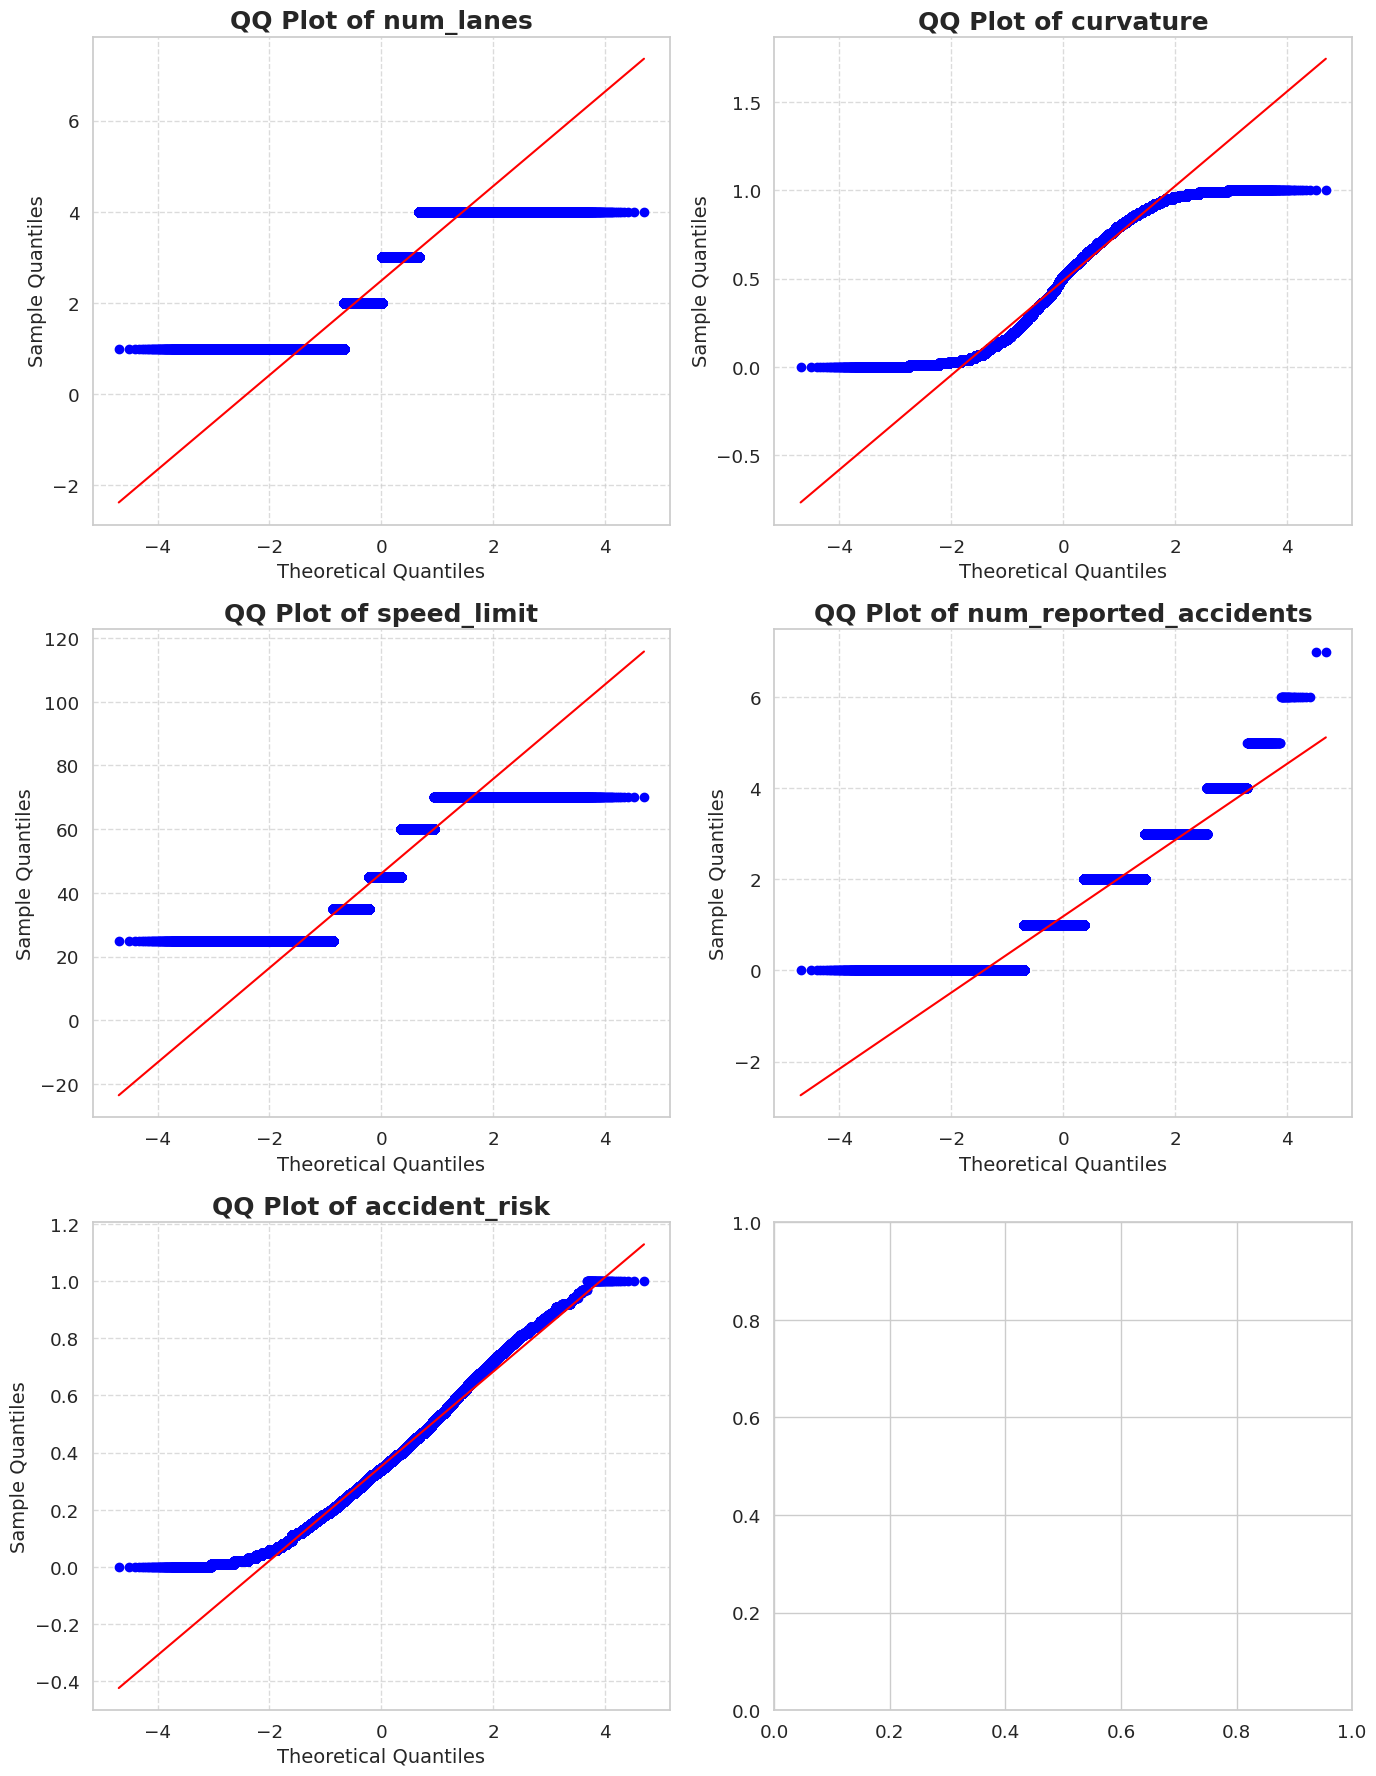

In [8]:
plot_qq_plot(train)

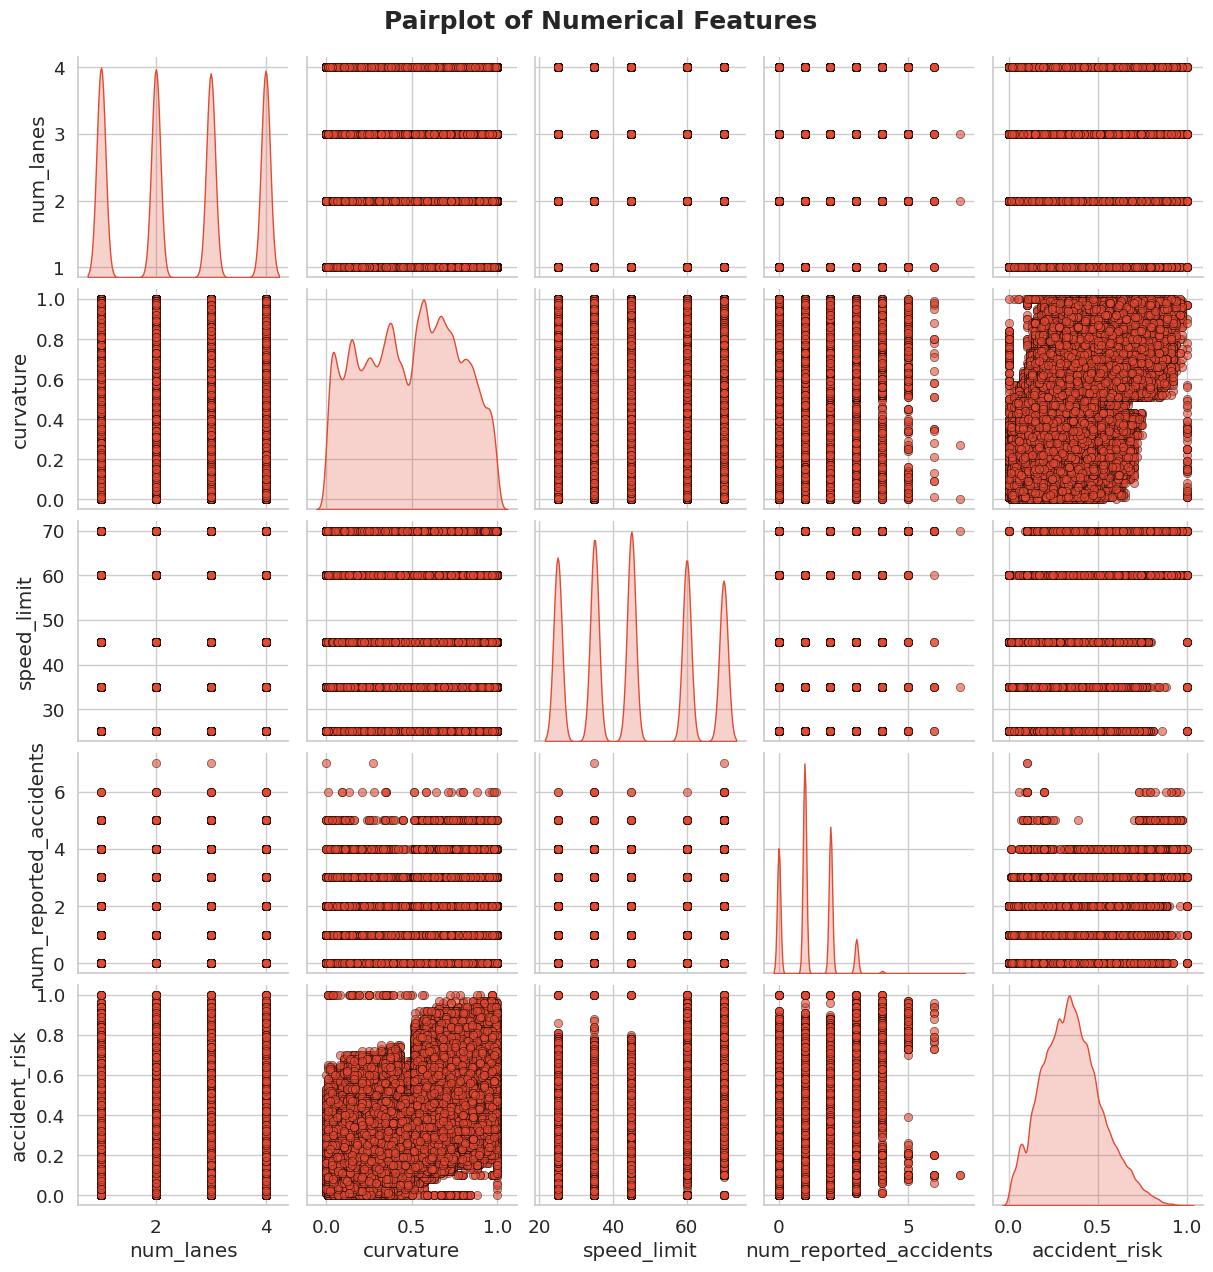

In [9]:
plot_pairplot(train)

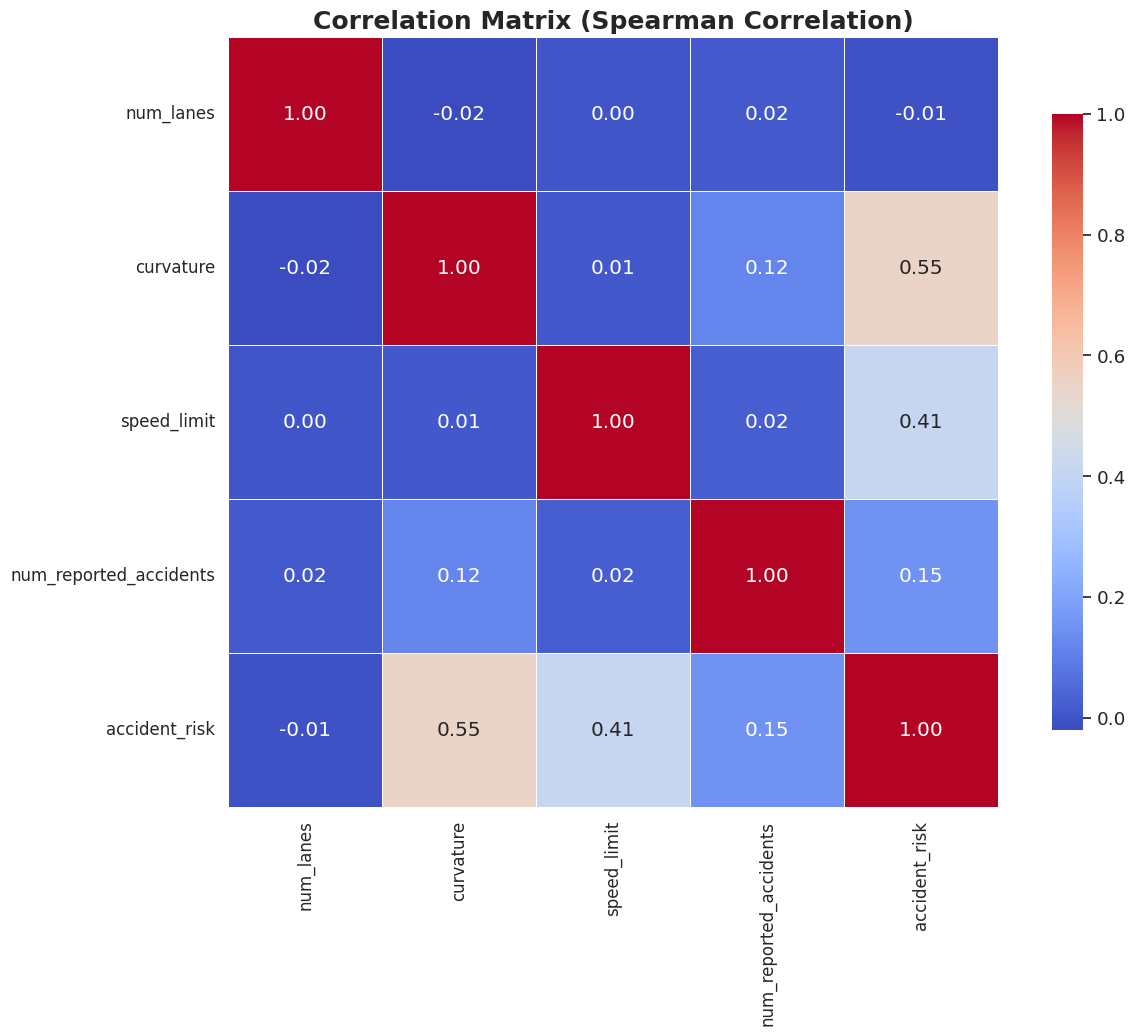

In [10]:
plot_correlation_matrix(train)

In [11]:
X = sm.add_constant(train.select_dtypes(include=[np.number]).iloc [:, 1:])

VIFs = pd.DataFrame()
VIFs['Variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

                 Variable        VIF
0                   const  13.729896
1               curvature   1.559211
2             speed_limit   1.353074
3  num_reported_accidents   1.053232
4           accident_risk   1.971686


## Categorical features

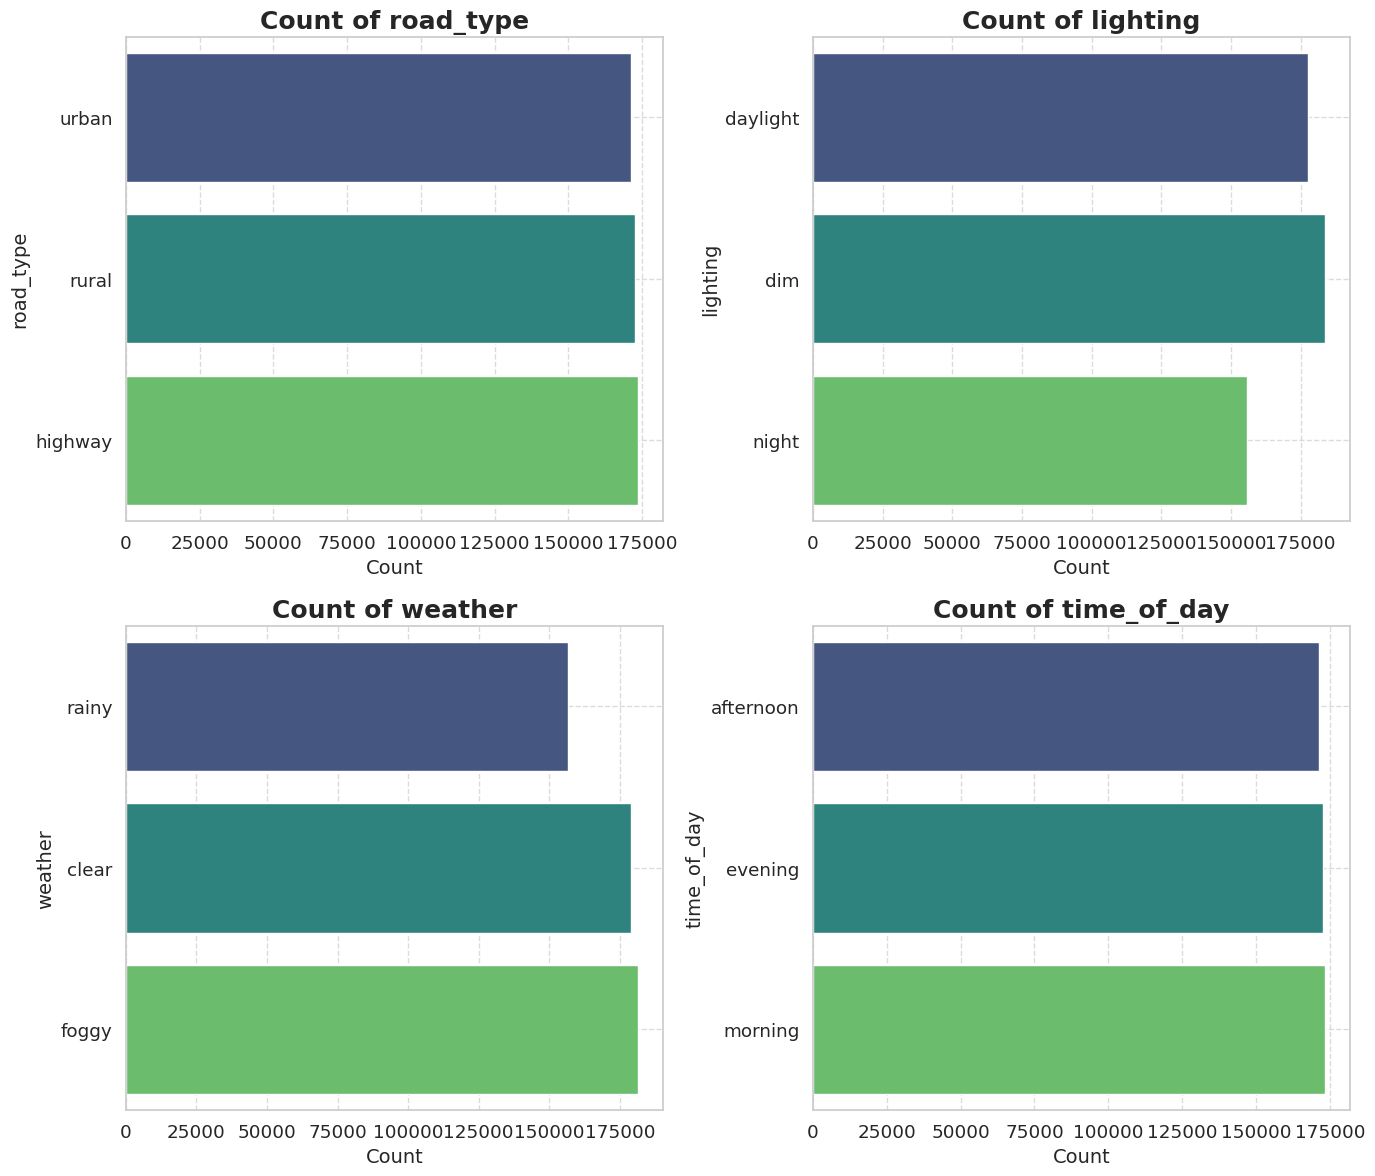

In [12]:
plot_categorical_features(train)

# New features

In [13]:
def create_features(df):
    df = df.copy()
    
    df['traffic_intensity'] = df['num_lanes'] * df['speed_limit'] / 10
    df['road_complexity'] = df['curvature'] * df['num_lanes']
    df['speed_curve_risk'] = df['curvature'] * (df['speed_limit'] / 50)
    
    df['poor_visibility'] = ((df['weather'].isin(['rainy', 'foggy', 'snowy'])) & 
                            (df['lighting'].isin(['dim', 'dark']))).astype(int)
    
    df['high_speed_curve'] = ((df['speed_limit'] > 60) & (df['curvature'] > 0.7)).astype(int)
    df['adverse_conditions'] = (df['poor_visibility'] | df['high_speed_curve']).astype(int)
    
    return df

train = create_features(train)
test = create_features(test)

display(train.shape, test.shape)
display(train.info(), test.info())

(517098, 19)

(172585, 18)

<class 'pandas.core.frame.DataFrame'>
Index: 517098 entries, 0 to 517753
Data columns (total 19 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517098 non-null  object 
 1   num_lanes               517098 non-null  int8   
 2   curvature               517098 non-null  float32
 3   speed_limit             517098 non-null  int8   
 4   lighting                517098 non-null  object 
 5   weather                 517098 non-null  object 
 6   road_signs_present      517098 non-null  bool   
 7   public_road             517098 non-null  bool   
 8   time_of_day             517098 non-null  object 
 9   holiday                 517098 non-null  bool   
 10  school_season           517098 non-null  bool   
 11  num_reported_accidents  517098 non-null  int8   
 12  accident_risk           517098 non-null  float32
 13  traffic_intensity       517098 non-null  float64
 14  road_complexity         5

None

None

In [14]:
def encode_time(time_str):
    time_mapping = {'morning': 6, 'afternoon': 12, 'evening': 18, 'night': 0}
    time_val = time_mapping[time_str]
    
    sin_time = np.sin(2 * np.pi * time_val / 24)
    cos_time = np.cos(2 * np.pi * time_val / 24)
    return sin_time, cos_time

train['time_sin'], train['time_cos'] = zip(*train['time_of_day'].apply(encode_time))
test['time_sin'], test['time_cos'] = zip(*test['time_of_day'].apply(encode_time))

display(train.shape, test.shape)

(517098, 21)

(172585, 20)

In [15]:
def add_target_encoding(train_df, test_df, categorical_cols):
    for col in categorical_cols:
        target_mean = train_df.groupby(col)['accident_risk'].mean()
        
        train_df[f'{col}_target_enc'] = train_df[col].map(target_mean)
        
        test_df[f'{col}_target_enc'] = test_df[col].map(target_mean)
        
        overall_mean = train_df['accident_risk'].mean()
        test_df[f'{col}_target_enc'].fillna(overall_mean, inplace=True)
    
    return train_df, test_df

categorical_cols = ['road_type', 'lighting', 'weather', 'time_of_day']
train, test = add_target_encoding(train, test, categorical_cols)

display(train.shape, test.shape)
display(train.info(), test.info())

(517098, 25)

(172585, 24)

<class 'pandas.core.frame.DataFrame'>
Index: 517098 entries, 0 to 517753
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   road_type               517098 non-null  object 
 1   num_lanes               517098 non-null  int8   
 2   curvature               517098 non-null  float32
 3   speed_limit             517098 non-null  int8   
 4   lighting                517098 non-null  object 
 5   weather                 517098 non-null  object 
 6   road_signs_present      517098 non-null  bool   
 7   public_road             517098 non-null  bool   
 8   time_of_day             517098 non-null  object 
 9   holiday                 517098 non-null  bool   
 10  school_season           517098 non-null  bool   
 11  num_reported_accidents  517098 non-null  int8   
 12  accident_risk           517098 non-null  float32
 13  traffic_intensity       517098 non-null  float64
 14  road_complexity         5

None

None

In [16]:
def add_statistical_features(train_df, test_df, group_cols):
    for col in group_cols:
        stats = train_df.groupby(col).agg({
            'accident_risk': ['mean', 'std', 'count']
        }).round(4)
        stats.columns = [f'{col}_risk_mean', f'{col}_risk_std', f'{col}_count']
        stats = stats.reset_index()
        
        train_df = train_df.merge(stats, on=col, how='left')
        
        test_df = test_df.merge(stats, on=col, how='left')
        
        overall_stats = train_df['accident_risk'].agg(['mean', 'std']).values
        test_df[f'{col}_risk_mean'].fillna(overall_stats[0], inplace=True)
        test_df[f'{col}_risk_std'].fillna(overall_stats[1], inplace=True)
        test_df[f'{col}_count'].fillna(len(train_df), inplace=True)
    
    return train_df, test_df

group_cols = ['road_type', 'weather', 'lighting', 'num_lanes']
train, test = add_statistical_features(train, test, group_cols)

display(train.shape, test.shape)

(517098, 37)

(172585, 36)

In [17]:
def add_interaction_features(df):
    df = df.copy()
    
    df['road_weather'] = df['road_type'] + '_' + df['weather']
    df['lighting_weather'] = df['lighting'] + '_' + df['weather']
    df['time_weather'] = df['time_of_day'] + '_' + df['weather']
    
    df['lanes_speed_interaction'] = df['num_lanes'] * df['speed_limit']
    df['curve_speed_ratio'] = df['curvature'] / (df['speed_limit'] + 1)  # +1 чтобы избежать деления на 0
    
    return df

train = add_interaction_features(train)
test = add_interaction_features(test)

display(train.shape, test.shape)

(517098, 42)

(172585, 41)

In [18]:
def add_binned_features(df):
    df = df.copy()
    
    speed_bins = [0, 30, 50, 60, 70]
    speed_labels = ['low', 'medium', 'high', 'very_high']
    df['speed_binned'] = pd.cut(df['speed_limit'], bins=speed_bins, labels=speed_labels)
    
    curvature_bins = [0, 0.3, 0.6, 1.0]
    curvature_labels = ['straight', 'moderate', 'curvy']
    df['curvature_binned'] = pd.cut(df['curvature'], bins=curvature_bins, labels=curvature_labels)
    
    return df

train = add_binned_features(train)
test = add_binned_features(test)

display(train.shape, test.shape)

(517098, 44)

(172585, 43)

# The final dataset

In [19]:
train_cols = set(train.columns)
test_cols = set(test.columns)

print("Columns in test but not in train:", test_cols - train_cols)
print("Columns in train but not in test:", train_cols - test_cols)

Columns in test but not in train: set()
Columns in train but not in test: {'accident_risk'}


In [20]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,...,num_lanes_risk_mean,num_lanes_risk_std,num_lanes_count,road_weather,lighting_weather,time_weather,lanes_speed_interaction,curve_speed_ratio,speed_binned,curvature_binned
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,...,0.3538,0.1673,129901,urban_rainy,daylight_rainy,afternoon_rainy,70,0.001667,medium,straight
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,...,0.3472,0.1650,128937,urban_clear,daylight_clear,evening_clear,-116,0.027500,medium,curvy
2,rural,4,0.63,70,dim,clear,False,True,morning,True,...,0.3472,0.1650,128937,rural_clear,dim_clear,morning_clear,24,0.008873,very_high,curvy
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,...,0.3472,0.1650,128937,highway_rainy,dim_rainy,morning_rainy,-116,0.001944,medium,straight
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,...,0.3514,0.1661,131002,rural_foggy,daylight_foggy,evening_foggy,60,0.009508,high,moderate


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517098 entries, 0 to 517097
Data columns (total 44 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   road_type                517098 non-null  object  
 1   num_lanes                517098 non-null  int8    
 2   curvature                517098 non-null  float32 
 3   speed_limit              517098 non-null  int8    
 4   lighting                 517098 non-null  object  
 5   weather                  517098 non-null  object  
 6   road_signs_present       517098 non-null  bool    
 7   public_road              517098 non-null  bool    
 8   time_of_day              517098 non-null  object  
 9   holiday                  517098 non-null  bool    
 10  school_season            517098 non-null  bool    
 11  num_reported_accidents   517098 non-null  int8    
 12  accident_risk            517098 non-null  float32 
 13  traffic_intensity        517098 non-null  fl

In [22]:
object_category_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
print(object_category_cols)

['road_type', 'lighting', 'weather', 'time_of_day', 'road_weather', 'lighting_weather', 'time_weather', 'speed_binned', 'curvature_binned']


In [23]:
for col in object_category_cols:
        le = LabelEncoder()
        combined = pd.concat([train[col], test[col]], axis=0)
        le.fit(combined)
        
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])

display(train.shape, test.shape)
display(train.info(), test.info())

(517098, 44)

(172585, 43)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517098 entries, 0 to 517097
Data columns (total 44 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   road_type                517098 non-null  int64  
 1   num_lanes                517098 non-null  int8   
 2   curvature                517098 non-null  float32
 3   speed_limit              517098 non-null  int8   
 4   lighting                 517098 non-null  int64  
 5   weather                  517098 non-null  int64  
 6   road_signs_present       517098 non-null  bool   
 7   public_road              517098 non-null  bool   
 8   time_of_day              517098 non-null  int64  
 9   holiday                  517098 non-null  bool   
 10  school_season            517098 non-null  bool   
 11  num_reported_accidents   517098 non-null  int8   
 12  accident_risk            517098 non-null  float32
 13  traffic_intensity        517098 non-null  float64
 14  road

None

None

# Split data & threshold

In [24]:
X = train.drop(columns=['accident_risk'])
y = train['accident_risk']

#not today
X = variance_threshold(X,0.001)
list_name = (X.columns)
test = test[list_name]

display(X.shape, y.shape, test.shape)

(517098, 34)

(517098,)

(172585, 34)

# Optuna

In [25]:
def optimize_catboost_regression(X, y, n_trials=40, cv=5):
  
    def rmse_scorer(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
    rmse_score = make_scorer(rmse_scorer, greater_is_better=False)
    
    def objective(trial):
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1200),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'random_strength': trial.suggest_float('random_strength', 0, 2),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
            'loss_function': 'RMSE',
            'eval_metric': 'RMSE',
            'task_type': 'GPU', 
            'verbose': False,
            'early_stopping_rounds': 100
        }

        model = CatBoostRegressor(**params)
        
        
        scores = cross_val_score(model, X, y, cv=cv, 
                               scoring=rmse_score, n_jobs=1)
        
       
        return scores.mean()
    
    study = optuna.create_study(direction='maximize')  
    study.optimize(objective, n_trials=n_trials)
    
    return study

catboost_studies = []
for i in range(3):
    print(f"\nRunning CatBoost Regression optimization {i+1}/3")
    study = optimize_catboost_regression(X, y, n_trials=40)
    catboost_studies.append(study)
    print(f"Best trial {i+1}:")
    print(f"  Value (-RMSE): {study.best_value:.5f}")
    print(f"  Actual RMSE: {-study.best_value:.5f}")  
    print(f"  Params: {study.best_params}")


catboost_rmse_params = []

for i, study in enumerate(catboost_studies):
    params = study.best_params.copy()
    params['loss_function'] = 'RMSE'
    params['eval_metric'] = 'RMSE'
    params['verbose'] = False
    catboost_rmse_params.append(params)
    print(f"\nBest parameters for model {i+1}:")
    for key, value in params.items():
        print(f"  {key}: {value}")


print("\n" + "="*50)
print("OPTIMIZATION SUMMARY")
print("="*50)
for i, (study, params) in enumerate(zip(catboost_studies, catboost_rmse_params)):
    print(f"Model {i+1}: RMSE = {-study.best_value:.5f}")

config_0 = {
  'iterations': 537,
  'depth': 8,
  'learning_rate': 0.017842162028402962,
  'l2_leaf_reg': 7.370412244865911,
  'border_count': 191,
  'random_strength': 1.1087121186242526,
  'bagging_temperature': 0.6239080010677365,
  'grow_policy': 'Depthwise',
  'min_data_in_leaf': 27,
  'loss_function': 'RMSE',
  'eval_metric': 'RMSE',
  'verbose': False
}

config_1 = {
  'iterations': 950,
  'depth': 8,
  'learning_rate': 0.018571742536927362,
  'l2_leaf_reg': 4.524357457928256,
  'border_count': 153,
  'random_strength': 0.4862818740678978,
  'bagging_temperature': 0.4014679810273516,
  'grow_policy': 'Depthwise',
  'min_data_in_leaf': 25,
  'loss_function': 'RMSE',
  'eval_metric': 'RMSE',
  'verbose': False
}

config_2 = {
  'iterations': 301,
  'depth': 8,
  'learning_rate': 0.04484782966119428,
  'l2_leaf_reg': 2.8119862594836165,
  'border_count': 102,
  'random_strength': 0.8375799223678608,
  'bagging_temperature': 0.874858527606345,
  'grow_policy': 'Depthwise',
  'min_data_in_leaf': 3,
  'loss_function': 'RMSE',
  'eval_metric': 'RMSE',
  'verbose': False

}

catboost_rmse_params.append(config_0)
catboost_rmse_params.append(config_1)
catboost_rmse_params.append(config_2)

[I 2025-10-17 12:00:52,348] A new study created in memory with name: no-name-8a3c568f-d15e-445b-b310-8b9e7e9bc8a2



Running CatBoost Regression optimization 1/3


[I 2025-10-17 12:01:44,546] Trial 0 finished with value: -0.056212014907077855 and parameters: {'iterations': 740, 'depth': 10, 'learning_rate': 0.013220990031206064, 'l2_leaf_reg': 6.550234646083725, 'border_count': 132, 'random_strength': 0.035417899321876556, 'bagging_temperature': 0.06415739233640483, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 18}. Best is trial 0 with value: -0.056212014907077855.
[I 2025-10-17 12:02:12,083] Trial 1 finished with value: -0.05634951251254098 and parameters: {'iterations': 800, 'depth': 4, 'learning_rate': 0.051984960564736477, 'l2_leaf_reg': 8.452216964056516, 'border_count': 247, 'random_strength': 0.7209759467567751, 'bagging_temperature': 0.6321714628885258, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 11}. Best is trial 0 with value: -0.056212014907077855.
[I 2025-10-17 12:03:42,572] Trial 2 finished with value: -0.056075640402100634 and parameters: {'iterations': 915, 'depth': 9, 'learning_rate': 0.011709300355966883, 'l2_leaf_reg'

Best trial 1:
  Value (-RMSE): -0.05607
  Actual RMSE: 0.05607
  Params: {'iterations': 1064, 'depth': 8, 'learning_rate': 0.011260544823325768, 'l2_leaf_reg': 2.823213060128606, 'border_count': 233, 'random_strength': 0.6373822912358093, 'bagging_temperature': 0.7864099853508072, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 42}

Running CatBoost Regression optimization 2/3


[I 2025-10-17 12:38:05,686] Trial 0 finished with value: -0.05636038870822134 and parameters: {'iterations': 912, 'depth': 6, 'learning_rate': 0.018816932222758362, 'l2_leaf_reg': 6.332724475115803, 'border_count': 146, 'random_strength': 0.9455928964625198, 'bagging_temperature': 0.6860763564071597, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 48}. Best is trial 0 with value: -0.05636038870822134.
[I 2025-10-17 12:38:18,774] Trial 1 finished with value: -0.056469700595124975 and parameters: {'iterations': 307, 'depth': 7, 'learning_rate': 0.03373384560151739, 'l2_leaf_reg': 7.5714817397225245, 'border_count': 38, 'random_strength': 0.08014584693478, 'bagging_temperature': 0.46076860623076055, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 10}. Best is trial 0 with value: -0.05636038870822134.
[I 2025-10-17 12:39:56,195] Trial 2 finished with value: -0.057968856686868256 and parameters: {'iterations': 771, 'depth': 10, 'learning_rate': 0.09063046411098524, 'l2_leaf_reg': 4.

Best trial 2:
  Value (-RMSE): -0.05607
  Actual RMSE: 0.05607
  Params: {'iterations': 580, 'depth': 8, 'learning_rate': 0.02046262294274999, 'l2_leaf_reg': 9.946976403789428, 'border_count': 167, 'random_strength': 0.16390086148364288, 'bagging_temperature': 0.819667215584951, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 36}

Running CatBoost Regression optimization 3/3


[I 2025-10-17 13:06:35,168] Trial 0 finished with value: -0.056236997997614835 and parameters: {'iterations': 254, 'depth': 10, 'learning_rate': 0.050785705136168015, 'l2_leaf_reg': 4.068902785604302, 'border_count': 189, 'random_strength': 0.5836040522042156, 'bagging_temperature': 0.8351018012268352, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 29}. Best is trial 0 with value: -0.056236997997614835.
[I 2025-10-17 13:07:04,954] Trial 1 finished with value: -0.056361389526776405 and parameters: {'iterations': 987, 'depth': 7, 'learning_rate': 0.013360340168268814, 'l2_leaf_reg': 1.7045276512513157, 'border_count': 157, 'random_strength': 1.6765560116190952, 'bagging_temperature': 0.5551029871567927, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 13}. Best is trial 0 with value: -0.056236997997614835.
[I 2025-10-17 13:07:31,886] Trial 2 finished with value: -0.05645014322102633 and parameters: {'iterations': 1066, 'depth': 6, 'learning_rate': 0.01840538471603706, 'l2_leaf_re

Best trial 3:
  Value (-RMSE): -0.05607
  Actual RMSE: 0.05607
  Params: {'iterations': 717, 'depth': 8, 'learning_rate': 0.013371273698490496, 'l2_leaf_reg': 2.0980860249920052, 'border_count': 153, 'random_strength': 1.149501717988201, 'bagging_temperature': 0.5061063396139158, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 17}

Best parameters for model 1:
  iterations: 1064
  depth: 8
  learning_rate: 0.011260544823325768
  l2_leaf_reg: 2.823213060128606
  border_count: 233
  random_strength: 0.6373822912358093
  bagging_temperature: 0.7864099853508072
  grow_policy: Depthwise
  min_data_in_leaf: 42
  loss_function: RMSE
  eval_metric: RMSE
  verbose: False

Best parameters for model 2:
  iterations: 580
  depth: 8
  learning_rate: 0.02046262294274999
  l2_leaf_reg: 9.946976403789428
  border_count: 167
  random_strength: 0.16390086148364288
  bagging_temperature: 0.819667215584951
  grow_policy: Depthwise
  min_data_in_leaf: 36
  loss_function: RMSE
  eval_metric: RMSE
  verbose:

In [26]:
def optimize_xgboost_regression(X, y, n_trials=40, cv=5):
   
    def rmse_scorer(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
    rmse_score = make_scorer(rmse_scorer, greater_is_better=False)
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 2),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'max_delta_step': trial.suggest_int('max_delta_step', 0, 5),
            'eval_metric': 'rmse',
            'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
            'max_leaves': trial.suggest_int('max_leaves', 32, 256),
            'max_bin': trial.suggest_int('max_bin', 128, 256),
            'tree_method': 'gpu_hist',
            'predictor': 'gpu_predictor',
            'sampling_method': trial.suggest_categorical('sampling_method', ['uniform', 'gradient_based'])
        }
        
        model = xgb.XGBRegressor(**params)
        
        scores = cross_val_score(model, X, y, cv=cv, 
                               scoring=rmse_score, n_jobs=1)
        
        return scores.mean()
    
    study = optuna.create_study(direction='maximize')  
    study.optimize(objective, n_trials=n_trials)
    
    return study


xgb_studies = []
for i in range(3):
    print(f"\nRunning XGBoost Regression optimization {i+1}/3")
    study = optimize_xgboost_regression(X, y, n_trials=40)
    xgb_studies.append(study)
    print(f"Best trial {i+1}:")
    print(f"  Value (-RMSE): {study.best_value:.5f}")
    print(f"  Actual RMSE: {-study.best_value:.5f}")  
    print(f"  Params: {study.best_params}")

xgb_rmse_params = []
for i, study in enumerate(xgb_studies):
    params = study.best_params.copy()
    params.update({
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'eval_metric': 'rmse'
    })
    xgb_rmse_params.append(params)
    print(f"\nXGBoost config {i+1}:")
    for key, value in params.items():
        print(f"  {key}: {value}")

print("\n" + "="*50)
print("XGBOOST OPTIMIZATION SUMMARY")
print("="*50)
for i, (study, params) in enumerate(zip(xgb_studies, xgb_rmse_params)):
    print(f"Model {i+1}: RMSE = {-study.best_value:.5f}")

config_0 = {
    
  'n_estimators': 760,
  'max_depth': 10,
  'learning_rate': 0.013795917955898896,
  'subsample': 0.7267734213015471,
  'colsample_bytree': 0.711424372302688,
  'gamma': 0.004090103222241464,
  'min_child_weight': 8,
  'reg_lambda': 0.3471752674396913,
  'reg_alpha': 0.6283614659091622,
  'max_delta_step': 2,
  'grow_policy': 'lossguide',
  'max_leaves': 215,
  'max_bin': 243,
  'sampling_method': 'gradient_based',
  'tree_method': 'gpu_hist',
  'predictor': 'gpu_predictor',
  'eval_metric': 'rmse',
    
}

config_2 = {
    
  'n_estimators': 396,
  'max_depth': 12,
  'learning_rate': 0.02054786311244503,
  'subsample': 0.8006661157443362,
  'colsample_bytree': 0.926330943646608,
  'gamma': 0.020881547833851988,
  'min_child_weight': 2,
  'reg_lambda': 0.9947304284610006,
  'reg_alpha': 0.8364558915124849,
  'max_delta_step': 5,
  'grow_policy': 'lossguide',
  'max_leaves': 148,
  'max_bin': 219,
  'sampling_method': 'uniform',
  'tree_method': 'gpu_hist',
  'predictor': 'gpu_predictor',
  'eval_metric': 'rmse',
    
}

config_2 = {
    
  'n_estimators': 551,
  'max_depth': 6,
  'learning_rate': 0.0503127818403867,
  'subsample': 0.6017365244797307,
  'colsample_bytree': 0.7777128943498162,
  'gamma': 0.0018954277087720513,
  'min_child_weight': 2,
  'reg_lambda': 0.8471823203750417,
  'reg_alpha': 0.6262587504812429,
  'max_delta_step': 5,
  'grow_policy': 'depthwise',
  'max_leaves': 59,
  'max_bin': 130,
  'sampling_method': 'gradient_based',
  'tree_method': 'gpu_hist',
  'predictor': 'gpu_predictor',
  'eval_metric': 'rmse',
}

xgb_rmse_params.append(config_0)
xgb_rmse_params.append(config_1)
xgb_rmse_params.append(config_2)

[I 2025-10-17 13:27:56,342] A new study created in memory with name: no-name-03c97b4e-3e5e-4ae2-b6b2-e6aae989772c



Running XGBoost Regression optimization 1/3


[I 2025-10-17 13:28:11,146] Trial 0 finished with value: -0.0793999895453453 and parameters: {'n_estimators': 260, 'max_depth': 3, 'learning_rate': 0.006305911508424642, 'subsample': 0.6520191566435569, 'colsample_bytree': 0.8906932944020547, 'gamma': 0.3001980779748118, 'min_child_weight': 6, 'reg_lambda': 0.6599299674936591, 'reg_alpha': 0.948532826510047, 'max_delta_step': 4, 'grow_policy': 'lossguide', 'max_leaves': 254, 'max_bin': 232, 'sampling_method': 'gradient_based'}. Best is trial 0 with value: -0.0793999895453453.
[I 2025-10-17 13:28:33,695] Trial 1 finished with value: -0.05678138881921768 and parameters: {'n_estimators': 603, 'max_depth': 12, 'learning_rate': 0.012692934487809051, 'subsample': 0.6736397129840215, 'colsample_bytree': 0.6276944643571497, 'gamma': 0.6617084048041819, 'min_child_weight': 7, 'reg_lambda': 1.927348186267881, 'reg_alpha': 0.2702482304054926, 'max_delta_step': 0, 'grow_policy': 'depthwise', 'max_leaves': 203, 'max_bin': 185, 'sampling_method': 'u

Best trial 1:
  Value (-RMSE): -0.05605
  Actual RMSE: 0.05605
  Params: {'n_estimators': 1047, 'max_depth': 12, 'learning_rate': 0.007355404134556128, 'subsample': 0.9298568401773203, 'colsample_bytree': 0.7807251690441908, 'gamma': 0.002938647099727927, 'min_child_weight': 8, 'reg_lambda': 1.5030303056481393, 'reg_alpha': 0.4243034640376139, 'max_delta_step': 4, 'grow_policy': 'lossguide', 'max_leaves': 242, 'max_bin': 174, 'sampling_method': 'gradient_based'}

Running XGBoost Regression optimization 2/3


[I 2025-10-17 14:01:52,086] Trial 0 finished with value: -0.05684434324502945 and parameters: {'n_estimators': 805, 'max_depth': 7, 'learning_rate': 0.043891402695802495, 'subsample': 0.7318838773039575, 'colsample_bytree': 0.8943225823567559, 'gamma': 0.8680872820937283, 'min_child_weight': 4, 'reg_lambda': 0.1667541255284146, 'reg_alpha': 0.8909050762381693, 'max_delta_step': 0, 'grow_policy': 'lossguide', 'max_leaves': 219, 'max_bin': 168, 'sampling_method': 'uniform'}. Best is trial 0 with value: -0.05684434324502945.
[I 2025-10-17 14:02:20,044] Trial 1 finished with value: -0.06781623512506485 and parameters: {'n_estimators': 236, 'max_depth': 8, 'learning_rate': 0.006160793318763632, 'subsample': 0.8336945318075437, 'colsample_bytree': 0.8138867027230179, 'gamma': 0.24890592642949405, 'min_child_weight': 6, 'reg_lambda': 1.3316444781927645, 'reg_alpha': 0.7248138039834996, 'max_delta_step': 3, 'grow_policy': 'lossguide', 'max_leaves': 222, 'max_bin': 210, 'sampling_method': 'grad

Best trial 2:
  Value (-RMSE): -0.05610
  Actual RMSE: 0.05610
  Params: {'n_estimators': 514, 'max_depth': 12, 'learning_rate': 0.023652541517747067, 'subsample': 0.7202768958594703, 'colsample_bytree': 0.7509921793631915, 'gamma': 0.0018339827104395627, 'min_child_weight': 3, 'reg_lambda': 1.328193284099025, 'reg_alpha': 0.29498745180575986, 'max_delta_step': 3, 'grow_policy': 'lossguide', 'max_leaves': 77, 'max_bin': 239, 'sampling_method': 'uniform'}

Running XGBoost Regression optimization 3/3


[I 2025-10-17 14:19:10,450] Trial 0 finished with value: -0.05667704194784164 and parameters: {'n_estimators': 778, 'max_depth': 7, 'learning_rate': 0.06337073534416696, 'subsample': 0.6810835205033455, 'colsample_bytree': 0.6742383518074865, 'gamma': 0.4088933868553978, 'min_child_weight': 3, 'reg_lambda': 1.501511268154295, 'reg_alpha': 0.8820141651523868, 'max_delta_step': 4, 'grow_policy': 'lossguide', 'max_leaves': 137, 'max_bin': 135, 'sampling_method': 'uniform'}. Best is trial 0 with value: -0.05667704194784164.
[I 2025-10-17 14:19:26,317] Trial 1 finished with value: -0.05866491943597794 and parameters: {'n_estimators': 169, 'max_depth': 8, 'learning_rate': 0.015280569167581779, 'subsample': 0.8465164390800713, 'colsample_bytree': 0.8626591218631358, 'gamma': 0.7818576559731955, 'min_child_weight': 10, 'reg_lambda': 1.5857078070865074, 'reg_alpha': 0.9246253949968195, 'max_delta_step': 3, 'grow_policy': 'lossguide', 'max_leaves': 41, 'max_bin': 158, 'sampling_method': 'uniform

Best trial 3:
  Value (-RMSE): -0.05611
  Actual RMSE: 0.05611
  Params: {'n_estimators': 367, 'max_depth': 9, 'learning_rate': 0.059699440313294945, 'subsample': 0.9425225039826202, 'colsample_bytree': 0.6456678623826004, 'gamma': 0.00017891863324782063, 'min_child_weight': 8, 'reg_lambda': 0.5979954462491327, 'reg_alpha': 0.2739906349483838, 'max_delta_step': 1, 'grow_policy': 'depthwise', 'max_leaves': 120, 'max_bin': 231, 'sampling_method': 'gradient_based'}

XGBoost config 1:
  n_estimators: 1047
  max_depth: 12
  learning_rate: 0.007355404134556128
  subsample: 0.9298568401773203
  colsample_bytree: 0.7807251690441908
  gamma: 0.002938647099727927
  min_child_weight: 8
  reg_lambda: 1.5030303056481393
  reg_alpha: 0.4243034640376139
  max_delta_step: 4
  grow_policy: lossguide
  max_leaves: 242
  max_bin: 174
  sampling_method: gradient_based
  tree_method: gpu_hist
  predictor: gpu_predictor
  eval_metric: rmse

XGBoost config 2:
  n_estimators: 514
  max_depth: 12
  learning_ra

In [27]:
def optimize_lightgbm_regression(X, y, n_trials=40, cv=5):
    
    def rmse_scorer(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))
    
    rmse_score = make_scorer(rmse_scorer, greater_is_better=False)
    
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
            'num_leaves': trial.suggest_int('num_leaves', 20, 128),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
            'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 0.1),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
            'min_split_gain': trial.suggest_float('min_split_gain', 0, 0.2),
            'path_smooth': trial.suggest_float('path_smooth', 0, 1),
            'max_bin': trial.suggest_int('max_bin', 64, 255),
            'extra_trees': trial.suggest_categorical('extra_trees', [True, False]),
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'objective': 'regression',
            'metric': 'rmse',
            'verbose': -1
        }
        
        model = LGBMRegressor(**params)
        
        scores = cross_val_score(model, X, y, cv=cv, 
                               scoring=rmse_score, n_jobs=1)
        
        return scores.mean()
    
    study = optuna.create_study(direction='maximize') 
    study.optimize(objective, n_trials=n_trials)
    
    return study


lgbm_studies = []
for i in range(3):
    print(f"\nRunning LightGBM Regression optimization {i+1}/3")
    study = optimize_lightgbm_regression(X, y, n_trials=40)
    lgbm_studies.append(study)
    print(f"Best trial {i+1}:")
    print(f"  Value (-RMSE): {study.best_value:.5f}")
    print(f"  Actual RMSE: {-study.best_value:.5f}")  
    print(f"  Params: {study.best_params}")


lgbm_rmse_params = []
for i, study in enumerate(lgbm_studies):
    params = study.best_params.copy()
    params.update({
        'device': 'gpu',
        'objective': 'regression',
        'metric': 'rmse',
        'verbose': -1
    })
    lgbm_rmse_params.append(params)
    print(f"\nLightGBM config {i+1}:")
    for key, value in params.items():
        print(f"  {key}: {value}")


print("\n" + "="*50)
print("LIGHTGBM OPTIMIZATION SUMMARY")
print("="*50)
for i, (study, params) in enumerate(zip(lgbm_studies, lgbm_rmse_params)):
    print(f"Model {i+1}: RMSE = {-study.best_value:.5f}")

config_0 = {
    
  'n_estimators': 475,
  'max_depth': 6,
  'learning_rate': 0.02609566703640587,
  'num_leaves': 126,
  'min_child_samples': 10,
  'min_child_weight': 0.08696250243662902,
  'feature_fraction': 0.6040602458875166,
  'bagging_fraction': 0.8208724518623647,
  'bagging_freq': 3,
  'lambda_l1': 0.361298537906501,
  'lambda_l2': 0.3227120302947219,
  'min_split_gain': 0.0001271057985094303,
  'path_smooth': 0.02245717701896824,
  'max_bin': 243,
  'extra_trees': False,
  'device': 'gpu',
  'objective': 'regression',
  'metric': 'rmse',
  'verbose': -1,

}

config_1 = {
    
  'n_estimators': 729,
  'max_depth': 11,
  'learning_rate': 0.019579347467589887,
  'num_leaves': 51,
  'min_child_samples': 36,
  'min_child_weight': 0.07029393408032038,
  'feature_fraction': 0.8046195627507132,
  'bagging_fraction': 0.9548143084700726,
  'bagging_freq': 3,
  'lambda_l1': 0.08652123482408915,
  'lambda_l2': 0.11178179927007909,
  'min_split_gain': 0.000188284436315936,
  'path_smooth': 0.5054225516315782,
  'max_bin': 182,
  'extra_trees': False,
  'device': 'gpu',
  'objective': 'regression',
  'metric': 'rmse',
  'verbose': -1

}

config_2 = {
    
  'n_estimators': 830,
  'max_depth': 10,
  'learning_rate': 0.032717852791327814,
  'num_leaves': 58,
  'min_child_samples': 29,
  'min_child_weight': 0.022821245946439715,
  'feature_fraction': 0.9419990343992585,
  'bagging_fraction': 0.9090572699720074,
  'bagging_freq': 6,
  'lambda_l1': 0.16396068014180826,
  'lambda_l2': 0.6153088612059665,
  'min_split_gain': 0.000978174955847403,
  'path_smooth': 0.7739653148026253,
  'max_bin': 114,
  'extra_trees': False,
  'device': 'gpu',
  'objective': 'regression',
  'metric': 'rmse',
  'verbose': -1

}

lgbm_rmse_params.append(config_0)
lgbm_rmse_params.append(config_1)
lgbm_rmse_params.append(config_2)

[I 2025-10-17 14:32:49,199] A new study created in memory with name: no-name-417cfd8f-eb2f-4e1e-8d5a-dadfddd9d92b



Running LightGBM Regression optimization 1/3


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
[I 2025-10-17 14:33:52,393] Trial 0 finished with value: -0.05679603052989175 and parameters: {'n_estimators': 684, 'max_depth': 4, 'learning_rate': 0.013009828742569902, 'num_leaves': 53, 'min_child_samples': 22, 'min_child_weight': 0.050790117304886605, 'feature_fraction': 0.8131089085055998, 'bagging_fr

Best trial 1:
  Value (-RMSE): -0.05612
  Actual RMSE: 0.05612
  Params: {'n_estimators': 795, 'max_depth': 11, 'learning_rate': 0.018932446232167943, 'num_leaves': 69, 'min_child_samples': 50, 'min_child_weight': 0.047504456955759465, 'feature_fraction': 0.694694709860526, 'bagging_fraction': 0.8199280185387303, 'bagging_freq': 4, 'lambda_l1': 0.6077862435945974, 'lambda_l2': 0.9844740992537802, 'min_split_gain': 0.0011030198839511972, 'path_smooth': 0.012885024647985244, 'max_bin': 191, 'extra_trees': False}

Running LightGBM Regression optimization 2/3


[I 2025-10-17 15:27:19,845] Trial 0 finished with value: -0.05657660829659737 and parameters: {'n_estimators': 545, 'max_depth': 11, 'learning_rate': 0.013804331819904654, 'num_leaves': 32, 'min_child_samples': 15, 'min_child_weight': 0.016261374418967366, 'feature_fraction': 0.7932661989791038, 'bagging_fraction': 0.8844769672026642, 'bagging_freq': 8, 'lambda_l1': 0.9900911705749527, 'lambda_l2': 0.7501014192536969, 'min_split_gain': 0.09427544423902678, 'path_smooth': 0.4132361125527251, 'max_bin': 111, 'extra_trees': False}. Best is trial 0 with value: -0.05657660829659737.
[I 2025-10-17 15:28:26,451] Trial 1 finished with value: -0.06089310717496965 and parameters: {'n_estimators': 532, 'max_depth': 4, 'learning_rate': 0.007034773994203235, 'num_leaves': 22, 'min_child_samples': 41, 'min_child_weight': 0.059082391330030286, 'feature_fraction': 0.8373874852044283, 'bagging_fraction': 0.7746240497668846, 'bagging_freq': 10, 'lambda_l1': 0.16997440017549137, 'lambda_l2': 0.6328767473

Best trial 2:
  Value (-RMSE): -0.05616
  Actual RMSE: 0.05616
  Params: {'n_estimators': 254, 'max_depth': 11, 'learning_rate': 0.03550799847101681, 'num_leaves': 71, 'min_child_samples': 42, 'min_child_weight': 0.035745942534592026, 'feature_fraction': 0.8500960243814142, 'bagging_fraction': 0.6760492818396778, 'bagging_freq': 6, 'lambda_l1': 0.7342749704081847, 'lambda_l2': 0.4364016356115964, 'min_split_gain': 0.00045645604235163006, 'path_smooth': 0.6147206387104577, 'max_bin': 143, 'extra_trees': False}

Running LightGBM Regression optimization 3/3


[I 2025-10-17 16:00:47,384] Trial 0 finished with value: -0.056831786079007005 and parameters: {'n_estimators': 556, 'max_depth': 9, 'learning_rate': 0.07162394133511908, 'num_leaves': 24, 'min_child_samples': 15, 'min_child_weight': 0.01595365170935794, 'feature_fraction': 0.6238136475610068, 'bagging_fraction': 0.7686054209797818, 'bagging_freq': 3, 'lambda_l1': 0.65899814889186, 'lambda_l2': 0.059990740076708904, 'min_split_gain': 0.1859895879480469, 'path_smooth': 0.15316005666293564, 'max_bin': 169, 'extra_trees': False}. Best is trial 0 with value: -0.056831786079007005.
[I 2025-10-17 16:01:17,799] Trial 1 finished with value: -0.056517273770834084 and parameters: {'n_estimators': 1034, 'max_depth': 10, 'learning_rate': 0.0879642719565717, 'num_leaves': 52, 'min_child_samples': 20, 'min_child_weight': 0.06773220711316627, 'feature_fraction': 0.6849816509627216, 'bagging_fraction': 0.8090946857574152, 'bagging_freq': 9, 'lambda_l1': 0.7655232256137445, 'lambda_l2': 0.1595751040929

Best trial 3:
  Value (-RMSE): -0.05615
  Actual RMSE: 0.05615
  Params: {'n_estimators': 905, 'max_depth': 8, 'learning_rate': 0.007702175613028408, 'num_leaves': 85, 'min_child_samples': 44, 'min_child_weight': 0.03546205985726844, 'feature_fraction': 0.7256540058156683, 'bagging_fraction': 0.9065514070374212, 'bagging_freq': 3, 'lambda_l1': 0.33291872114330595, 'lambda_l2': 0.683356828978077, 'min_split_gain': 0.0007910090894712085, 'path_smooth': 0.8199818969384945, 'max_bin': 206, 'extra_trees': False}

LightGBM config 1:
  n_estimators: 795
  max_depth: 11
  learning_rate: 0.018932446232167943
  num_leaves: 69
  min_child_samples: 50
  min_child_weight: 0.047504456955759465
  feature_fraction: 0.694694709860526
  bagging_fraction: 0.8199280185387303
  bagging_freq: 4
  lambda_l1: 0.6077862435945974
  lambda_l2: 0.9844740992537802
  min_split_gain: 0.0011030198839511972
  path_smooth: 0.012885024647985244
  max_bin: 191
  extra_trees: False
  device: gpu
  objective: regression
  

# Model

In [28]:
gb_params_list = [
        {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 
         'random_state': 42, 'subsample': 0.8},
        {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 7, 
         'random_state': 42, 'subsample': 0.9},
        {'n_estimators': 150, 'learning_rate': 0.2, 'max_depth': 3, 
         'random_state': 42, 'subsample': 0.7}
    ]

et_params_list = [
        {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 5, 
         'random_state': 42, 'n_jobs': -1},
        {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 2, 
         'random_state': 42, 'n_jobs': -1}
    ]

hgb_params_list = [
        {'max_iter': 200, 'learning_rate': 0.1, 'max_depth': 10, 
         'random_state': 42, 'l2_regularization': 0.1},
        {'max_iter': 300, 'learning_rate': 0.05, 'max_depth': 15, 
         'random_state': 42, 'l2_regularization': 0.01}
    ]

ada_params_list = [
        {'n_estimators': 100, 'learning_rate': 0.1, 'random_state': 42},
        {'n_estimators': 200, 'learning_rate': 0.05, 'random_state': 42}
    ]

bagging_params = [
        {'n_estimators': 20, 'random_state': 42, 'n_jobs': -1},
        {'n_estimators': 50, 'random_state': 42, 'n_jobs': -1}
    ]

linear_models = [
        ('ridge', Ridge(alpha=1.0, random_state=42)),
        ('lasso', Lasso(alpha=0.1, random_state=42)),
        ('elastic', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42))
    ]

In [29]:
def create_ensemble(X, y, test, n_folds=5):
    FOLDS = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    all_oof = {}
    all_predictions = {}
    models = []

    for i, params in enumerate(catboost_rmse_params, 1):
        models.append((f'cat_{i}', CatBoostRegressor(**params)))
    
    for i, params in enumerate(xgb_rmse_params, 1):
        models.append((f'xgb_{i}', xgb.XGBRegressor(**params, n_jobs=1)))
    
    for i, params in enumerate(lgbm_rmse_params, 1):
        models.append((f'lgb_{i}', LGBMRegressor(**params, n_jobs=1)))

    for i, params in enumerate(gb_params_list, 1):
        models.append((f'gb_{i}', GradientBoostingRegressor(**params)))

    for i, params in enumerate(et_params_list, 1):
        models.append((f'et_{i}', ExtraTreesRegressor(**params)))

    for i, params in enumerate(hgb_params_list, 1):
        models.append((f'hgb_{i}', HistGradientBoostingRegressor(**params)))

    for i, params in enumerate(ada_params_list, 1):
        models.append((f'ada_{i}', AdaBoostRegressor(**params)))

    for i, params in enumerate(bagging_params, 1):
        models.append((f'bag_{i}', BaggingRegressor(**params)))

    for name, model in linear_models:
        models.append((f'linear_{name}', model))
    
    for name, model in models:
        try:
            print(f"\nTraining {name}...")
            oof = np.zeros(len(X))
            pred = np.zeros(len(test))
            
            for fold, (trn_idx, val_idx) in enumerate(FOLDS.split(X, y)):
                X_train, y_train = X.iloc[trn_idx], y.iloc[trn_idx]
                X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
                
                model.fit(X_train, y_train)
                oof[val_idx] = model.predict(X_val)
                pred += model.predict(test) / FOLDS.n_splits
                
                fold_rmse = np.sqrt(mean_squared_error(y_val, oof[val_idx]))
                print(f'{name} - Fold {fold} RMSE: {fold_rmse:.4f}')
            
            all_oof[name] = oof
            all_predictions[name] = pred
            
            full_rmse = np.sqrt(mean_squared_error(y, oof))
            print(f'{name} - Full OOF RMSE: {full_rmse:.4f}')
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            continue
    
    oof_df = pd.DataFrame(all_oof)
    predictions_df = pd.DataFrame(all_predictions)
    
    oof_df['target'] = y.values
    
    model_info = {
        'model_names': [name for name, _ in models],
        'num_models': len(models),
        'features_used': list(X.columns),
        'used_log_transform': False
    }
    
    return oof_df, predictions_df, model_info

oof_results, test_predictions, model_info = create_ensemble(X, y, test)
    
oof_results.to_csv('oof_predictions.csv', index=False)
test_predictions.to_csv('test_predictions.csv', index=False)

print("\nModeling completed successfully!")
print(f"Trained {model_info['num_models']} models")
print("OOF predictions shape:", oof_results.shape)
print("Test predictions shape:", test_predictions.shape)


Training cat_1...
cat_1 - Fold 0 RMSE: 0.0560
cat_1 - Fold 1 RMSE: 0.0563
cat_1 - Fold 2 RMSE: 0.0562
cat_1 - Fold 3 RMSE: 0.0561
cat_1 - Fold 4 RMSE: 0.0561
cat_1 - Full OOF RMSE: 0.0561

Training cat_2...
cat_2 - Fold 0 RMSE: 0.0559
cat_2 - Fold 1 RMSE: 0.0563
cat_2 - Fold 2 RMSE: 0.0561
cat_2 - Fold 3 RMSE: 0.0560
cat_2 - Fold 4 RMSE: 0.0560
cat_2 - Full OOF RMSE: 0.0561

Training cat_3...
cat_3 - Fold 0 RMSE: 0.0561
cat_3 - Fold 1 RMSE: 0.0564
cat_3 - Fold 2 RMSE: 0.0563
cat_3 - Fold 3 RMSE: 0.0562
cat_3 - Fold 4 RMSE: 0.0562
cat_3 - Full OOF RMSE: 0.0562

Training cat_4...
cat_4 - Fold 0 RMSE: 0.0561
cat_4 - Fold 1 RMSE: 0.0564
cat_4 - Fold 2 RMSE: 0.0563
cat_4 - Fold 3 RMSE: 0.0562
cat_4 - Fold 4 RMSE: 0.0562
cat_4 - Full OOF RMSE: 0.0562

Training cat_5...
cat_5 - Fold 0 RMSE: 0.0559
cat_5 - Fold 1 RMSE: 0.0563
cat_5 - Fold 2 RMSE: 0.0562
cat_5 - Fold 3 RMSE: 0.0560
cat_5 - Fold 4 RMSE: 0.0560
cat_5 - Full OOF RMSE: 0.0561

Training cat_6...
cat_6 - Fold 0 RMSE: 0.0560
cat_6 - 

# Mix & blend

In [30]:
def create_optimal_ensemble(oof_results, test_predictions, y):
   
    oof_predictions = oof_results.drop(['target'], axis=1, errors='ignore')
    y_true = oof_results['target'] if 'target' in oof_results else y
    
    ridge = Ridge(alpha=1.0)
    ridge.fit(oof_predictions, y_true)
    ridge_pred = ridge.predict(oof_predictions)
    ridge_rmse = np.sqrt(mean_squared_error(y_true, ridge_pred))
    
    def objective(weights):
        weighted_pred = np.dot(oof_predictions.values, weights)
        return np.sqrt(mean_squared_error(y_true, weighted_pred))
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = [(0, 1)] * len(oof_predictions.columns)
    initial_weights = np.ones(len(oof_predictions.columns)) / len(oof_predictions.columns)
    
    result = minimize(objective, initial_weights, 
                     method='SLSQP', bounds=bounds, constraints=constraints)
    optimized_weights = result.x
    optimized_pred = np.dot(oof_predictions.values, optimized_weights)
    optimized_rmse = np.sqrt(mean_squared_error(y_true, optimized_pred))
    
    if ridge_rmse <= optimized_rmse:
        print(f"Using Ridge (RMSE: {ridge_rmse:.4f})")
        test_pred = ridge.predict(test_predictions)
        weights = ridge.coef_
    else:
        print(f"Using Optimized Weights (RMSE: {optimized_rmse:.4f})")
        test_pred = np.dot(test_predictions.values, optimized_weights)
        weights = optimized_weights
    
    weights = weights / weights.sum()
    
    return test_pred, weights, min(ridge_rmse, optimized_rmse)

test_pred, weights, best_rmse = create_optimal_ensemble(oof_results, test_predictions, y)

print(f"\nBest Ensemble RMSE: {best_rmse:.4f}")
print("Final weights:")
for model, weight in zip(test_predictions.columns, weights):
    print(f"  {model}: {weight:.4f}")

Using Ridge (RMSE: 0.0560)

Best Ensemble RMSE: 0.0560
Final weights:
  cat_1: 0.0109
  cat_2: 0.1228
  cat_3: -0.0973
  cat_4: -0.1195
  cat_5: 0.1200
  cat_6: 0.0172
  xgb_1: 0.4774
  xgb_2: 0.0673
  xgb_3: 0.0392
  xgb_4: 0.1385
  xgb_6: -0.0007
  lgb_1: 0.0502
  lgb_2: -0.0526
  lgb_3: -0.0200
  lgb_4: -0.0533
  lgb_5: 0.0732
  lgb_6: 0.0542
  gb_1: 0.0454
  gb_2: 0.0108
  gb_3: -0.0198
  et_1: 0.1160
  et_2: -0.0344
  hgb_1: 0.0308
  hgb_2: 0.0403
  ada_1: -0.0112
  ada_2: 0.0102
  bag_1: -0.0005
  bag_2: -0.0117
  linear_ridge: -0.0035
  linear_lasso: 0.0015
  linear_elastic: -0.0017


# Submit

In [31]:
sample = pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')
sample['accident_risk'] = test_pred
sample.to_csv('submission.csv', index=False)
sample.head(10)

,id,accident_risk
0,517754,0.295565
1,517755,0.120751
2,517756,0.177550
3,517757,0.311629
4,517758,0.404302
5,517759,0.461195
6,517760,0.260537
7,517761,0.199276
8,517762,0.371761
9,517763,0.325968
